# ARID1A acetylproteomics cis comparison

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [44]:
en_object = cptac.Endometrial()
desired_cutoff = .1

endometrial_freq_mut = al.get_frequently_mutated(en_object, cutoff=desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(endometrial_freq_mut), '\n', endometrial_freq_mut.head())

                                    

Number of Frequently Mutated Genes: 232 
      Gene  Unique_Samples_Mut  Missence_Mut  Truncation_Mut
0  ABCA12            0.147368      0.094737        0.073684
1  ABCA13            0.115789      0.105263        0.042105
2  ACVR2A            0.105263      0.010526        0.094737
3  ADGRG4            0.136842      0.126316        0.021053
4  ADGRV1            0.115789      0.094737        0.052632


## Step 3: Select a gene from the list of frequently mutated genes above

Set the gene to which of the above frequently mutated genes you want to examine. For example, if you want to look at the gene PTEN, change the cell below to say "gene = 'KRAS'"

In [45]:
gene = 'ARID1A'

## Step 4: Select desired omics comparison

Select which type of omics you want to compare. If you want to compare proteomics data for the interacting proteins, uncomment the "omics = en.get_proteomics()" line, etc.

In [46]:
omics = en_object.get_acetylproteomics()

omics.head()
omics_and_mutations = en_object.join_omics_to_mutations(
        mutations_genes = gene, omics_df_name = 'acetylproteomics', omics_genes = 'ARID1A')
omics_and_mutations.head()

,ARID1A-K1662_acetylproteomics,ARID1A-K1819_acetylproteomics,ARID1A-K1880_acetylproteomics,ARID1A-K1953_acetylproteomics,ARID1A-K250_acetylproteomics,ARID1A-K980_acetylproteomics,ARID1A_Mutation,ARID1A_Location,ARID1A_Mutation_Status,Sample_Status
Sample_ID,,,,,,,,,,
S001,NaN,NaN,NaN,NaN,NaN,NaN,[Missense_Mutation],[p.T2121P],Single_mutation,Tumor
S002,NaN,NaN,NaN,-0.178,NaN,NaN,"[Nonsense_Mutation, Frame_Shift_Del]","[p.Q403*, p.D1850Tfs*33]",Multiple_mutation,Tumor
S003,NaN,NaN,NaN,-0.675,-2.570,-0.134,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
S005,NaN,0.24,NaN,0.337,NaN,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
S006,NaN,NaN,NaN,NaN,0.779,0.251,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor


## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

In [47]:
# Step 2 - create binary column
omics_and_mutations['binary_mutations'] = omics_and_mutations[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')
tumors = omics_and_mutations.loc[omics_and_mutations['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status", "binary_mutations"]
acetyl_mutations = tumors.drop(columns_to_drop, axis = 1)

In [36]:
print("Doing t-test comparison for mutation status\n")
pval_df = pd.DataFrame()
bin_mut = tumors['binary_mutations'] # binary for tumor (no Normal samples)
all_acetyl = pd.DataFrame()

for col_label, content in acetyl_mutations.items():
    omics_col_list = [col_label] #list of specific column label of the loop
    existing_measurements = content.to_frame().dropna() #drop missing phospho measurements in specific col
    acetyl_col = existing_measurements.join(bin_mut, how = 'inner') 
    
    # Combine all data to use with boxplot
    #specific_acetyl = acetyl_tumors.assign(acetyl = col_label)
    #print(specific_phospho)
    all_acetyl = all_acetyl.append(acetyl_col, ignore_index = True) 
    
    
    # check correctly formatted
    check_binary = len(phsph_tumors['binary_mutations'].unique()) == 2
    check_not_empty = len(phsph_tumors.index) != 0
    if check_not_empty & check_binary:
        significant_pval_results = al.wrap_ttest(phsph_tumors, 'binary_mutations', omics_col_list)
        pval_df = pval_df.append(significant_pval_results, ignore_index = True)
print(pval_df)

#all_acetyl_df = pd.melt(all_acetyl, id_vars=['acetyl','binary_mutations'], value_name= 'Acetylproteomics')


Doing t-test comparison for mutation status

Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
Incorrectly Formatted Dataframe!
                     Comparison   P_Value
0  ARID1A-K980_acetylproteomics  0.000319


In [50]:
tumors = omics_and_mutations.loc[omics_and_mutations['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
standard = tumors.drop(columns_to_drop, axis = 1)

In [68]:
n = pd.DataFrame()
appended_data = []
for col, content in standard.items():
    d = content.to_frame().assign(acetyl = col_label)
    appended_data = appended_data.append(d)
    
    
    all_acetyl_df = pd.melt(appended_data, id_vars=['acetyl','binary_mutations'], value_name= 'Acetylproteomics')
    
    #a = d.assign(acetyl = col_label)
    #all_acetyl = pd.concat([a])
n = pd.concat(appended_data, axis = 0)   
n

AttributeError: 'NoneType' object has no attribute 'columns'

TypeError: cannot perform reduce with flexible type

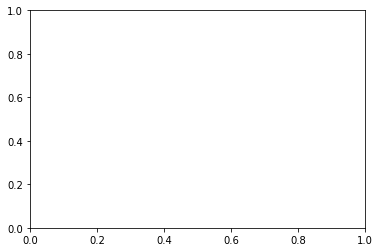

In [35]:
acetyl_list = list(all_acetyl.columns).remove('binary_mutations')

# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
en_cis_boxplot = sns.boxplot(data = tumors, x = 'binary_mutations',
                          y = acetyl_list, showfliers = False)  
en_cis_boxplot.set_title(gene + " cis Effect in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data= tumors, x = 'binary_mutations',
                            y = acetyl_list, jitter = True, color = ".3")
en_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Acetylproteomics")
plt.show()

In [10]:
en_type = f.get_missence_truncation_comparison(en_object, omics, 'transcriptomics', gene)
#print(en_type.head())

# T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(en_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

No significant comparisons.
None


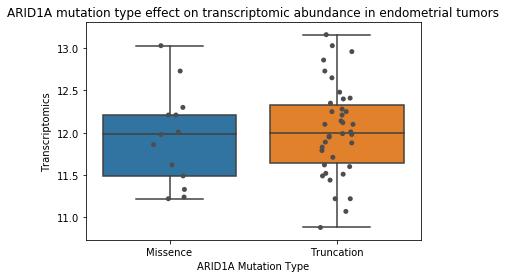

In [11]:
# Step 5 - Create boxplt to compare mutation type effect on omics data
en_cis_boxplot = sns.boxplot(data = en_type, x = 'binary_mutations',
                          y = 'ARID1A_transcriptomics', order = ["Missence","Truncation"], showfliers = False)  
en_cis_boxplot.set_title(gene + " mutation type effect on transcriptomic abundance in endometrial tumors")
en_cis_boxplot = sns.stripplot(data= en_type, x = 'binary_mutations',
                            y = 'ARID1A_transcriptomics',jitter = True, color = ".3", order = ["Missence","Truncation"])
en_cis_boxplot.set(xlabel = gene + " Mutation Type", ylabel = 'Transcriptomics')
plt.show()

# Repeat with the Colon dataset

Go through the same process, this time using the Colon dataset. We will only print five genes from the frequently mutated data frame for simplicity.

In [12]:
colon_object = cptac.Colon()
desired_cutoff = .1

colon_freq_mut = al.get_frequently_mutated(colon_object, cutoff=desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(colon_freq_mut), '\n', colon_freq_mut.head())

                                    

Number of Frequently Mutated Genes: 612 
         Unique_Samples_Mut  Missence_Mut  Truncation_Mut
Gene                                                    
ABCA13            0.195876      0.164948        0.103093
ABCA2             0.175258      0.164948        0.030928
ABCA4             0.144330      0.082474        0.061856
ABCB4             0.134021      0.061856        0.072165
ABCB6             0.103093      0.061856        0.041237


In [14]:
gene = 'ARID1A'

#co_omics = colon_object.get_proteomics()
co_omics = colon_object.get_transcriptomics()
#co_omics = colon_object.get_phosphoproteomics()
#co_omics = colon_object.get_acetylproteomics()

In [15]:
co_status = f.format_cis_comparison_data(colon_object, co_omics, 'transcriptomics', gene)
#co_data_for_comparison.head()

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(co_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

No significant comparisons.
None


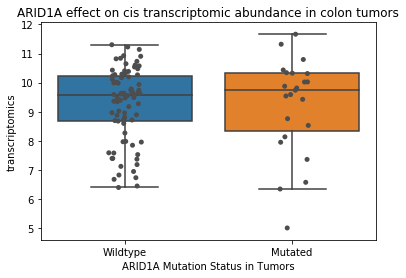

In [16]:
cis_boxplot = sns.boxplot(data = co_status, x = 'binary_mutations',
                          y = 'ARID1A_transcriptomics', order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " effect on cis transcriptomic abundance in colon tumors")
cis_boxplot = sns.stripplot(data = co_status, x = 'binary_mutations',
                            y = 'ARID1A_transcriptomics', jitter = True, color = ".3", 
                            order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "transcriptomics")
plt.show()

In [18]:
co_type = f.get_missence_truncation_comparison(colon_object, co_omics, 'transcriptomics', gene)

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(co_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

No significant comparisons.
None


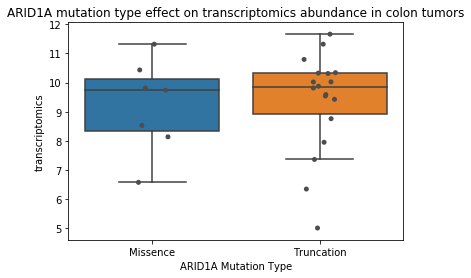

In [19]:

co_cis_boxplot = sns.boxplot(data = co_type, x = 'binary_mutations',
                          y = 'ARID1A_transcriptomics', order = ["Missence","Truncation"], showfliers = False)  
co_cis_boxplot.set_title(gene + " mutation type effect on transcriptomics abundance in colon tumors")
co_cis_boxplot = sns.stripplot(data= co_type, x = 'binary_mutations',
                            y = 'ARID1A_transcriptomics',jitter = True, color = ".3", order = ["Missence","Truncation"])
co_cis_boxplot.set(xlabel = gene + " Mutation Type", ylabel = 'transcriptomics')
plt.show()

# Repeat with the Ovarian dataset


In [20]:
ovarian_object = cptac.Ovarian()
desired_cutoff = .1

ovarian_freq_mut = al.get_frequently_mutated(ovarian_object, cutoff=desired_cutoff)

In [21]:
gene = 'ARID1A'

#ov_omics = ovarian_object.get_proteomics()
ov_omics = ovarian_object.get_transcriptomics()
#ov_omics = ovarian_object.get_phosphoproteomics()
#ov_omics = ovarian_object.get_acetylproteomics()

In [22]:
ov_status = f.format_cis_comparison_data(ovarian_object, ov_omics, 'transcriptomics', gene)

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(ov_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

No significant comparisons.
None


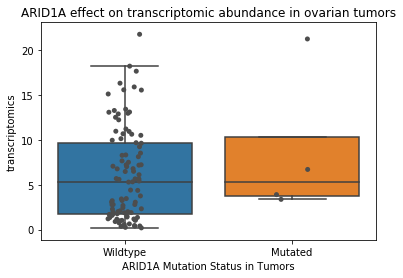

In [23]:
# Step 5 - Visualize comparison
ov_cis_boxplot = sns.boxplot(data = ov_status, x = 'binary_mutations',
                          y = 'ARID1A_transcriptomics', order = ["Wildtype","Mutated"], showfliers = False)  
ov_cis_boxplot.set_title(gene + " effect on transcriptomic abundance in ovarian tumors")
ov_cis_boxplot = sns.stripplot(
    data = ov_status, x = 'binary_mutations',y = 'ARID1A_transcriptomics', 
    jitter = True, color = ".3", order = ["Wildtype","Mutated"])
ov_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "transcriptomics")
plt.show()

Doing t-test comparison

No significant comparisons.
None


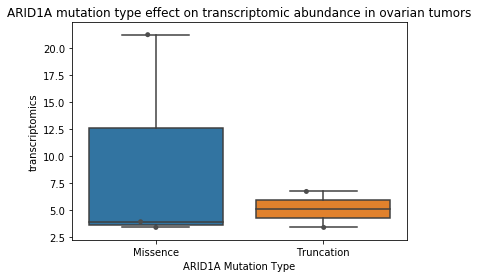

In [24]:
ov_type = f.get_missence_truncation_comparison(ovarian_object, ov_omics, 'transcriptomics', gene)

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(ov_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)

# Step 5 - Create boxplt to compare mutation type effect on omics data
en_cis_boxplot = sns.boxplot(data = ov_type, x = 'binary_mutations',
                          y = 'ARID1A_transcriptomics', order = ["Missence","Truncation"], showfliers = False)  
en_cis_boxplot.set_title(gene + " mutation type effect on transcriptomic abundance in ovarian tumors")
en_cis_boxplot = sns.stripplot(data= ov_type, x = 'binary_mutations',
                            y = 'ARID1A_transcriptomics',jitter = True, color = ".3", order = ["Missence","Truncation"])
en_cis_boxplot.set(xlabel = gene + " Mutation Type", ylabel = 'transcriptomics')
plt.show()

# Visualize Pancancer effects

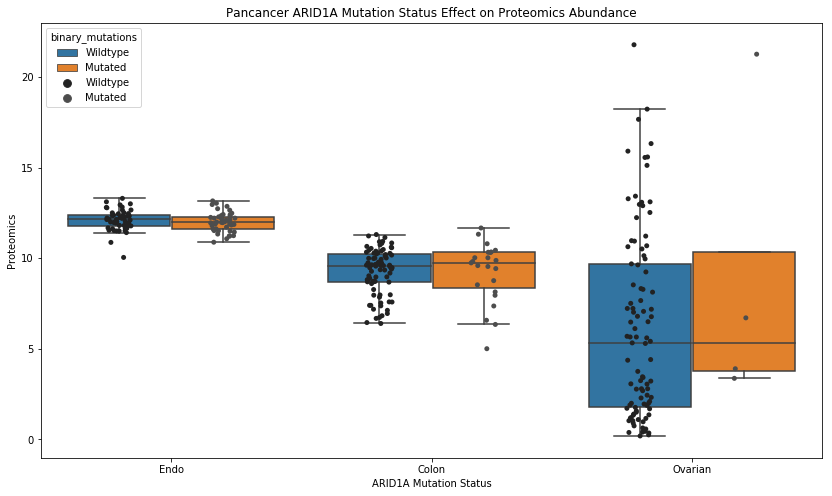

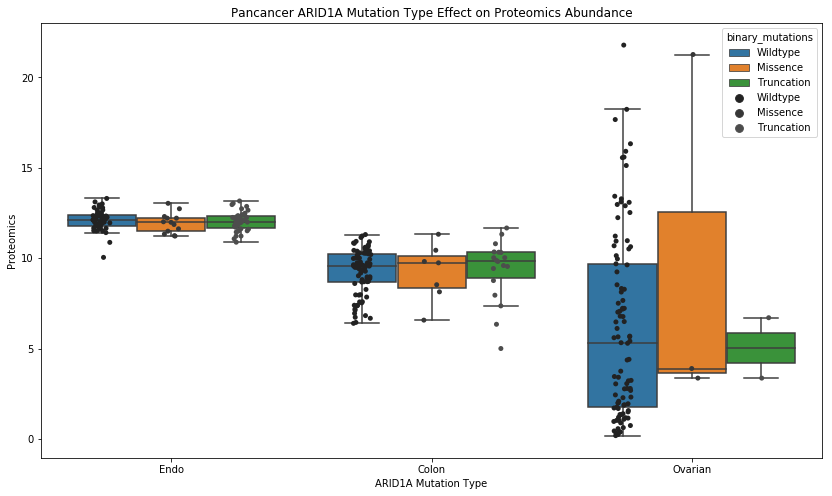

In [26]:
# Create a dataframe with pancancer data and labeling for mutation status (wildtype, mutated)
en_mut_status = en_status.assign(Cancer= 'Endo')
co_mut_status = co_status.assign(Cancer= 'Colon')
ov_mut_status = ov_status.assign(Cancer= 'Ovarian')
# mutation types (missence, truncation)
en_mut_type = en_type.assign(Cancer= 'Endo')
co_mut_type = co_type.assign(Cancer= 'Colon')
ov_mut_type = ov_type.assign(Cancer= 'Ovarian')

pancancer_data = pd.concat([en_mut_status, co_mut_status, ov_mut_status, en_mut_type, co_mut_type, ov_mut_type]) 
pancancer_df = pd.melt(pancancer_data, id_vars=['Cancer','binary_mutations'], value_name= 'Proteomics')  

# Visualize mutation status and categories accross cancers
plt.rcParams['figure.figsize']=(14,8) #size of plot
cis_status = sns.boxplot(
    x='Cancer', y="Proteomics", hue = 'binary_mutations', hue_order = ['Wildtype', 'Mutated'], data=pancancer_df, showfliers = False)    
cis_status.set_title('Pancancer ' + gene + " Mutation Status Effect on Proteomics Abundance")
cis_status = sns.stripplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', data=pancancer_df,
                            jitter = True, color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
cis_status.set(xlabel = gene + " Mutation Status", ylabel = 'Proteomics')

plt.show()

plt.clf()
plt.close()

cis_status = sns.boxplot(
    x='Cancer', y="Proteomics", hue = 'binary_mutations', hue_order = ['Wildtype', 'Missence', 'Truncation'], data = pancancer_df, showfliers = False)    
cis_status.set_title('Pancancer ' + gene + " Mutation Type Effect on Proteomics Abundance")
cis_status = sns.stripplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', data = pancancer_df,
                            jitter = True, color = ".3", hue_order = ['Wildtype', 'Missence', 'Truncation'], dodge = True)
cis_status.set(xlabel = gene + " Mutation Type", ylabel = 'Proteomics')
plt.rcParams['figure.figsize']=(14,8) #size of plot
plt.show()

plt.clf()
plt.close()